In [1]:
import os
import random
import torch
import numpy as np
import torch.utils.data
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.datasets as dset

from torch import nn, optim
from matplotlib import animation
from IPython.display import HTML
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
def smooth_data(x, k=5):
    '''平滑曲线'''
    kernel = np.ones(k)/k
    x_smooth = np.convolve(x, kernel, mode='valid')
    return x_smooth


def weights_init_normal(model):
    '''设置参数初始化方式为正态分布'''
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(model.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(model.bias.data, 0.0)


class Generator(nn.Module):
    '''手写数字生成器'''

    def __init__(self, img_size, z_dim, channels=1):
        super().__init__()
        self.z_dim = z_dim
        self.channels = channels
        # 一共经过4层 故2的4次幂
        self.init_size = img_size // 2**4
        self.input_layer = nn.Linear(self.z_dim, 64*self.init_size**2)
        def generator_blocks(infilters, outfilters, bn=True):
            '''定义模块函数'''
            # 每经过一层图像size扩大一倍
            blocks = [nn.ConvTranspose2d(
                infilters, outfilters, kernel_size=4, stride=2, padding=1, bias=False)]
            if bn:
                blocks.append(nn.BatchNorm2d(outfilters))
                blocks.append(nn.ReLU(True))
            else:
                blocks.append(nn.Tanh())
            return blocks
        self.model = nn.Sequential(
            # 输入: 4*4 输出: 64*64
            # 4*4 -> 8*8
            *generator_blocks(64, 128),
            # 8*8 -> 16*16
            *generator_blocks(128, 64),
            # 16*16 -> 32*32
            *generator_blocks(64, 32),
            # 32*32 -> 64*64
            *generator_blocks(32, self.channels, False)
        )

    def forward(self, input):
        out = self.input_layer(input)
        out = out.view(out.shape[0], -1, self.init_size, self.init_size)
        out = self.model(out)
        return out


class Discriminator(nn.Module):
    '''判别器'''

    def __init__(self, img_size, channels=1):
        super().__init__()
        def discriminator_block(in_filters, out_filters, bn=True):
            '''定义模块函数'''
            blocks = [
                nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.25)
            ]
            if bn:
                blocks.append(nn.BatchNorm2d(out_filters, 0.8))
            return blocks

        self.model = nn.Sequential(
            # 输入: 64*64
            # 64*64 -> 32*32
            *discriminator_block(channels, 16, bn=False),
            # 32*32 -> 16*16
            *discriminator_block(16, 32),
            # 16*16 -> 8*8
            *discriminator_block(32, 64),
            # 8*8 -> 4*4
            *discriminator_block(64, 128),
        )

        self.out_layer = nn.Sequential(
            nn.Linear(128 * 4 ** 2, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        out = self.out_layer(out)
        return out


def get_Generator(img_size, z_dim, state, channels=1):
    '''
    生成器模型获取
    state: bool类型，是否加载训练好的参数
    '''
    model = Generator(img_size, z_dim, channels)
    model.apply(weights_init_normal)
    if state:
        model_state = torch.load("models/dcgan_netG_state_final.pth")
        model.load_state_dict(model_state)
    return model


def get_Discriminator(img_size, state, channels=1):
    '''
    判别器模型获取
    state: bool类型，是否加载训练好的参数
    '''
    model = Discriminator(img_size, channels)
    model.apply(weights_init_normal)
    if state:
        model_state = torch.load("models/dcgan_netD_state_final.pth")
        model.load_state_dict(model_state)
    return model


In [3]:
# 定义随机生成的种子，确保每次训练结果一致
manualSeed = 20000
print("using random seed:", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# 定义有关超参数
PATH = "result/"
IMG_SIZE = 64
EPOCHS = 100
BATCH_SIZE = 128
TEST_BATCH_SIZE = 100
LR = 0.0002
Z_DIM = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: {}".format(DEVICE))
print("using torch vision: {}".format(torch.__version__))

using random seed: 20000
using device: cuda
using torch vision: 1.8.0+cu111


In [4]:
transform = transforms.Compose([
    # 更改图像大小
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    # 单通道不需要在3个channel中进行scale
    transforms.Normalize(mean=0.5, std=0.5)
])
# 定义训练和测试数据集
train_dataloader = torch.utils.data.DataLoader(
    dset.MNIST(
        root='data/mnist', train=True,
        download=True, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)
test_dataloaer = torch.utils.data.DataLoader(
    dset.MNIST(
        root="data/mnist",
        train=False,
        transform=transform
    ),
    batch_size=TEST_BATCH_SIZE
)

Using downloaded and verified file: data/mnist/MNIST/raw/train-images-idx3-ubyte.gz
Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw
Using downloaded and verified file: data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw


100.0%


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw


112.7%

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw
Processing...
Done!



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# 设置固定的噪声用于对比
fixed_noise = torch.rand(64, Z_DIM).to(DEVICE)
img_list = []
# 获取模型，False表示重新训练
netG = get_Generator(IMG_SIZE, Z_DIM, False).to(DEVICE)
netD = get_Discriminator(IMG_SIZE, False).to(DEVICE)
# 定义损失函数、优化器
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))

In [6]:
accR_L = []
accF_L = []
errDs = []
errGs = []
netD.train()
netG.train()
for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(train_dataloader):
        '''训练判别器'''
        # 正样本及其标签的获取
        netD.zero_grad()
        real_x = imgs.to(DEVICE)
        # 正样本标签 1
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        real_y = netD(real_x)
        # 负样本及其标签的获取
        z = torch.randn(BATCH_SIZE, Z_DIM).to(DEVICE)
        # 负样本标签 0
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        fake_x = netG(z)
        fake_y = netD(fake_x.detach())
        # 更新参数
        errD = criterion(real_y, real_labels) + \
            criterion(fake_y, fake_labels)
        errD.backward()
        optimizerD.step()
        # 计算判别器识别正负样本的准确率
        accR_L.append(real_y.data.mean().item())
        accF_L.append(fake_y.data.mean().item())
        '''训练生成器'''
        # 随机生成噪声输入
        netG.zero_grad()
        z = torch.randn(BATCH_SIZE, Z_DIM).to(DEVICE)
        fake_x = netG(z)
        fake_y = netD(fake_x)
        # 计算loss并更新参数
        errG = criterion(fake_y, real_labels)
        errG.backward()
        optimizerG.step()
        # 收集loss
        errDs.append(errD.item())
        errGs.append(errG.item())
    print("Epoch:[{} / {}] [D loss: {} | G loss: {}]".format(epoch+1, EPOCHS, errD, errG))
    if (epoch+1)%10==0:
        # 随时保存，防止崩溃
        torch.save(netD.state_dict(), PATH+"models/dcgan_netD_state_final.pth")
        torch.save(netG.state_dict(), PATH+"models/dcgan_netG_state_final.pth")
        '''生成若干数字并保存图像'''
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(
                fake, padding=2, normalize=True))
            # 保存过程图片
            save_image(fake, "{}images/dcgan_{}.jpg".format(PATH,epoch+1))


Epoch:[1 / 100] [D loss: 1.3661227226257324 | G loss: 0.8552753925323486]
Epoch:[2 / 100] [D loss: 1.286342978477478 | G loss: 0.898716390132904]
Epoch:[3 / 100] [D loss: 1.4139418601989746 | G loss: 0.7772055864334106]
Epoch:[4 / 100] [D loss: 1.354688286781311 | G loss: 0.6767425537109375]
Epoch:[5 / 100] [D loss: 1.415754795074463 | G loss: 0.9189858436584473]
Epoch:[6 / 100] [D loss: 1.4082590341567993 | G loss: 0.6396933794021606]
Epoch:[7 / 100] [D loss: 1.3127655982971191 | G loss: 0.6863048076629639]
Epoch:[8 / 100] [D loss: 1.3515338897705078 | G loss: 0.7440264225006104]
Epoch:[9 / 100] [D loss: 1.3757708072662354 | G loss: 0.7598545551300049]
Epoch:[10 / 100] [D loss: 1.2683414220809937 | G loss: 0.8103108406066895]
Epoch:[11 / 100] [D loss: 1.3236929178237915 | G loss: 0.7428776025772095]
Epoch:[12 / 100] [D loss: 1.349805235862732 | G loss: 0.8649775981903076]
Epoch:[13 / 100] [D loss: 1.3561402559280396 | G loss: 0.6809448003768921]
Epoch:[14 / 100] [D loss: 1.41627657413

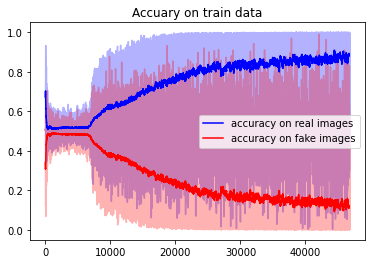

In [7]:
'''绘制训练集准确率'''
plt.figure(1)
plt.title("Accuary on train data")
plt.plot(accR_L, '-b', alpha=0.3)
plt.plot(accF_L, '-r', alpha=0.3)
plt.plot(smooth_data(accR_L, 120), '-b', label="accuracy on real images")
plt.plot(smooth_data(accF_L, 120), '-r', label='accuracy on fake images')
plt.legend()
plt.savefig(PATH+"images/DCGAN_Accuracy.jpg")


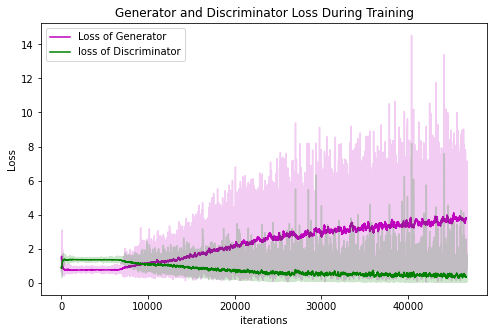

In [8]:
'''绘制Loss曲线'''
plt.figure(figsize=(8, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(errGs, "-m", alpha=0.2)
plt.plot(smooth_data(errGs, 120), "-m", label="Loss of Generator")
plt.plot(errDs, "-g", alpha=0.2)
plt.plot(smooth_data(errDs, 120), "-g", label="loss of Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(PATH+"images/DCGAN_Loss.jpg")


In [9]:
# 重设seed
test_manualSeed = manualSeed + 1000
print("Using random seed {} during testing".format(test_manualSeed))
random.seed(test_manualSeed)
torch.manual_seed(test_manualSeed)
accR_L_test = []
accF_L_test = []
netD.eval()
netG.eval()
for i, (imgs, _) in enumerate(test_dataloaer):
    real_x = imgs.to(DEVICE)
    real_labels = torch.ones(TEST_BATCH_SIZE, 1).to(DEVICE)
    real_y = netD(real_x)
    z = torch.randn(TEST_BATCH_SIZE, Z_DIM).to(DEVICE)
    fake_labels = torch.zeros(TEST_BATCH_SIZE, 1).to(DEVICE)
    fake_x = netG(z)
    fake_y = netD(fake_x.detach())
    accR_L_test.append(real_y.data.mean().item())
    accF_L_test.append(fake_y.data.mean().item())


Using random seed 21000 during testing


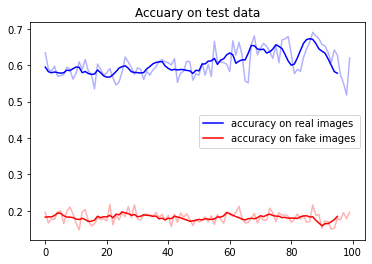

In [10]:
plt.figure(3)
plt.title("Accuary on test data")
plt.plot(smooth_data(accR_L_test, 5), '-b', label="accuracy on real images")
plt.plot(smooth_data(accF_L_test, 5), '-r', label='accuracy on fake images')
plt.plot(accR_L_test, '-b', alpha=0.3)
plt.plot(accF_L_test, '-r', alpha=0.3)
plt.legend()
plt.savefig(PATH+"images/accuary_on_test_data.jpg")


MovieWriter ffmpeg unavailable; using Pillow instead.


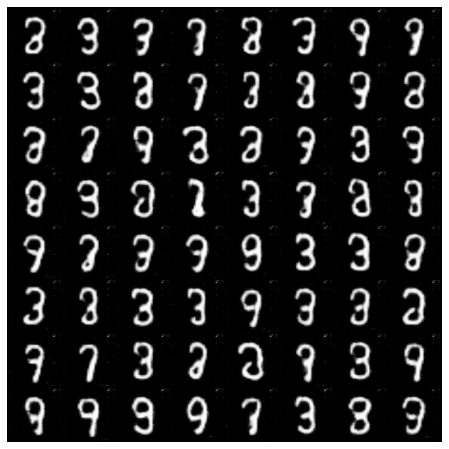

In [12]:
#%%capture
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)]
       for i in img_list]
ani = animation.ArtistAnimation(
    fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save(PATH+"images/generate.gif")
HTML(ani.to_jshtml())